In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
import optuna
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from optuna.integration import SkoptSampler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [3]:
data = pd.read_csv('_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# размер
data.shape

(3751, 1777)

1    0.542255
0    0.457745
Name: Activity, dtype: float64


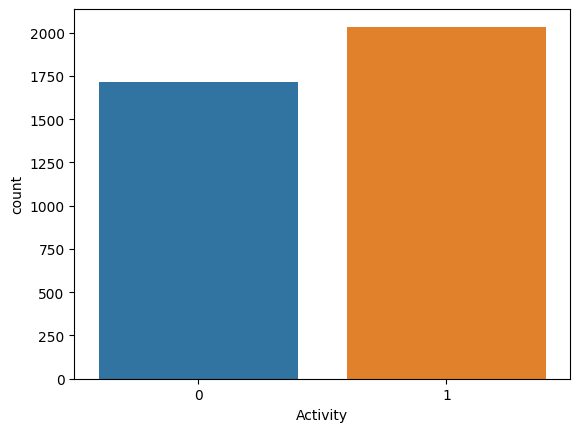

In [5]:
# сбалансированность классов
print(data['Activity'].value_counts(normalize=True))
sns.countplot(data=data, x='Activity');

In [6]:
# выделяем целевой признак
y = data['Activity']
X = data.drop(columns='Activity')

Наши данные относительно сбалансированны. При сбалансированных данных стратификация не является обязательной, но может быть полезной для уменьшения случайных отклонений в качестве модели. Поэтому добавим стратификацию. 

In [7]:
# разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y,
    test_size=0.2, 
    random_state=42
)

# Логистическая регрессия #

In [39]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(max_iter = 500)
#Обучаем модель на тренировочной выборке
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

В задании указано, что максимальное количество итераций не должно превышать 50. Но, алгоритм не сходится к решению за указанное количество итераций, генерируется предупреждение. Поэтому, выставлен минимально возможный параметр `max_iter`.

In [40]:
#Делаем предсказание 
y_test_pred_log = log_reg.predict(X_test)

In [41]:
#Зафиксируем метрику F1-меру для тестового набора без применения гиперпараметров
print('F1_score без применения параметров: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_log)))

F1_score без применения параметров: 0.78


## GridSearchCV ##

Стандартная сетка параметров для `GridSearchCV` зависит от выбранной модели и ее гиперпараметров. Здесь перебираются значения гиперпараметров `penalty`, `C`, `solver`. Для каждого из них задан список возможных значений.  `max_iter` по умолчанию равен 100

In [42]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.3, 0.5, 0.7, 1],
    'solver': ['newton-cg', 'lbfgs', 'saga']
}

model = linear_model.LogisticRegression()

grid_search = GridSearchCV(model, param_grid, n_jobs = -1, cv=5, scoring='f1')

%time grid_search.fit(X_train, y_train)
y_test_pred_grid = grid_search.predict(X_test)


print('F1_score GridSearch: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and 

CPU times: user 11.7 s, sys: 477 ms, total: 12.2 s
Wall time: 8min 8s
F1_score GridSearch: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1_score GridSearch: 0.78 Показатель не улучшился. 

## RandomizedSearchCV ##

In [32]:
param_distributions = {'penalty': ['l2', 'none'],
              'solver': ['L-BFGS-B', 'sag'],
              'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=500), 
    param_distributions=param_distributions, 
    cv=5, 
    n_jobs=-1,
    scoring='f1'
)  

%time random_search.fit(X_train, y_train) 

y_test_pred_rand = random_search.predict(X_test)
print('F1_score RandomizedSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rand)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and 

CPU times: user 4.94 s, sys: 104 ms, total: 5.05 s
Wall time: 2min 8s
F1_score RandomizedSearchCV: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


F1_score RandomizedSearchCV: 0.78 Показатель не улучшился. По сравнению с методом GridSearch время затрачено в два раза меньше.

## Hyperopt ##

In [12]:
# Определить функцию, которую будем оптимизировать
def objective(params):
    clf = linear_model.LogisticRegression(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return -score


In [13]:
# Определить пространство поиска гиперпараметров

space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -5, 5),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}


In [14]:
trials = Trials() # используется для логирования результатов

# Запустить оптимизацию гиперпараметров с помощью функции fmin
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  5%|▌         | 1/20 [00:30<09:32, 30.14s/trial, best loss: -0.7653983133599646]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 2/20 [01:09<10:39, 35.51s/trial, best loss: -0.7653983133599646]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▌        | 3/20 [01:12<05:54, 20.87s/trial, best loss: -0.7653983133599646]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 4/20 [01:43<06:32, 24.56s/trial, best loss: -0.7661983133599645]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 5/20 [02:16<06:56, 27.74s/trial, best loss: -0.7661983133599645]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [06:05<01:04, 16.09s/trial, best loss: -0.7661983133599645]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 17/20 [06:41<01:06, 22.16s/trial, best loss: -0.7661983133599645]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [07:10<00:48, 24.09s/trial, best loss: -0.7661983133599645]

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [07:17<00:00, 21.89s/trial, best loss: -0.7661983133599645]


In [27]:
# Получить лучшие значения гиперпараметров и обучить модель на всем наборе данных
best_params = {
    'penalty': ['l1', 'l2'][best['penalty']],
    'C': best['C'],
    'solver': ['liblinear', 'saga'][best['solver']]
}
clf = linear_model.LogisticRegression(**best_params)
clf.fit(X_train, y_train)
y_test_pred_hyperopt = clf.predict(X_test)
print('F1_score Hyperopt: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_hyperopt)))
print("Наилучшие значения гиперпараметров {}".format(best))

F1_score Hyperopt: 0.78
Наилучшие значения гиперпараметров {'C': 0.015585593260530151, 'penalty': 1, 'solver': 1}


/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1_score Hyperopt: 0.78 Показатель остался преждним. Причем при max_evals = 20 и max_evals = 100, модель показала одинаковый результат. За разное время. 

## Optuna ##

In [11]:
# Определение функции для оптимизации
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # создаем модель
    model = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=50)
    # обучаем модель
    model.fit(X_train, y_train)
    y_test_pred_optuna = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_optuna, average='binary')
    
    return f1


# Определение изучения и оптимизация гиперпараметров
sampler = SkoptSampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

print('Наилучшие значения гиперпараметров:', (study.best_params))
print('F1_score Optuna:', study.best_value)

[I 2023-06-18 15:36:57,580] A new study created in memory with name: no-name-0e97fdde-7b21-40f0-8a0c-db338c97d5fb
/tmp/ipykernel_43257/1476745135.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-18 15:36:59,360] Trial 0 finished with value: 0.7796610169491526 and parameters: {'C': 216.77186211913298, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.7796610169491526.
/tmp/ipykernel_43257/1476745135.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

Наилучшие значения гиперпараметров: {'C': 0.16039132678035503, 'penalty': 'l2', 'solver': 'liblinear'}
F1_score Optuna: 0.7851140456182473


In [8]:
# Определение функции для оптимизации
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # создаем модель
    model = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=50)
    # обучаем модель
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    return f1_scores.mean()


# Определение изучения и оптимизация гиперпараметров
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

print('Наилучшие значения гиперпараметров:', study.best_params)
print('F1_score Optuna:', study.best_value)

[I 2023-06-18 15:27:28,610] A new study created in memory with name: no-name-29a7c951-e2f7-4422-9353-9932c10c63f0
/tmp/ipykernel_43257/2158373616.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tatiana/.local/lib/python3.10/site-

Наилучшие значения гиперпараметров: {'C': 9703.767543782718, 'penalty': 'l2', 'solver': 'saga'}
F1_score Optuna: 0.776764692909644


Первый код оптимизирует гиперпараметры модели логистической регрессии с помощью Optuna и вычисляет F1-score на тестовой выборке. Второй код оптимизирует гиперпараметры модели логистической регрессии с помощью Optuna и вычисляет среднее значение F1-score на кросс-валидации. В первом случае нам удалось немного улучшить показатель. 

# Случайный лес #

Создаем модель с настройками по умолчанию, чтобы зафиксировать результат. 

In [13]:
# Создаем модель случайный лес
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Обучаем модель на обучающих данных
rf.fit(X_train, y_train)

# Получаем предсказания на тестовых данных
y_pred = rf.predict(X_test)

# Вычисляем F1-score на тестовых данных
f1 = f1_score(y_test, y_pred)

print('F1-score:', f1)

F1-score: 0.8048484848484848


## GridSearchCV ##

In [14]:
# Создаем модель случайный лес
rf = RandomForestClassifier(random_state=42)

# Задаем сетку гиперпараметров для перебора
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

# Обучаем модель на тренировочных данных
grid_search.fit(X_train, y_train)

# Получаем лучшие гиперпараметры и оценку качества модели на тестовых данных
best_params = grid_search.best_params_
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred)

print('Лучшие гиперпараметры:', best_params)
print('F1-score на тестовых данных:', f1)

Лучшие гиперпараметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
F1-score на тестовых данных: 0.8081534772182254


## RandomizedSearchCV ##

In [17]:
# Создаем модель случайный лес
rf = RandomForestClassifier(random_state=42)

# Задаем сетку гиперпараметров
param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Создаем объект RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=50,
    cv=5,
    random_state=42
)

# Обучаем модель на тренировочных данных
rf_random.fit(X_train, y_train)

# Получаем лучшие гиперпараметры
best_params = rf_random.best_params_

# Создаем модель с лучшими гиперпараметрами
rf_best = RandomForestClassifier(random_state=42, **best_params)

# Обучаем модель на тренировочных данных
rf_best.fit(X_train, y_train)

# Получаем предсказания на тестовых данных
y_pred = rf_best.predict(X_test)

# Оцениваем качество модели на тестовых данных
f1 = f1_score(y_test, y_pred)
print('F1-score:', f1)

F1-score: 0.784688995215311


## Hyperopt ##

In [19]:
# Определяем пространство поиска гиперпараметров
space = {
    'n_estimators': hp.choice('n_estimators', range(1, 5)),
    'max_depth': hp.choice('max_depth', range(1, 5)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

# Определяем функцию для минимизации (в данном случае - максимизации F1-score)
def objective(params):
    clf = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1').mean()
    return -score

# Запускаем поиск гиперпараметров
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Обучаем модель с лучшими найденными гиперпараметрами
clf = RandomForestClassifier(**best, random_state=42)
clf.fit(X_train, y_train)

# Оцениваем качество модели на тестовой выборке
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred)
print('F1-score:', score)

100%|██████████| 50/50 [00:30<00:00,  1.61trial/s, best loss: -0.7907714530423238]
F1-score: 0.7049608355091385


Количество параметров минимальне, чтобы сократить работу модели. Из-за этого результат самый низкий. В модели с применением Hyperopt можно увеличить параметры 'n_estimators' и 'max_depth', тогда точность модели будет выше, соответственно время работы алгоритма тоже увеличится. В модели Optuna можно увеличить параметр n_trials=10, хотя и при заданном параметре можель показала очеь хороший результат по скорости и по точности. 

## Optuna ##

In [21]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
    max_depth = trial.suggest_int('max_depth', 5, 50, 5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, 
                                  max_features=max_features, random_state=42)
    
    f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    return f1_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_score = study.best_value

print(f'Best F1-score: {best_score:.4f}')
print(f'Best parameters: {best_params}')

clf = RandomForestClassifier(**best_params, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f'F1-score on test set: {f1:.4f}')

[I 2023-06-18 16:16:16,593] A new study created in memory with name: no-name-bdc9b079-1905-404f-ad70-f65f605d2d8c
[I 2023-06-18 16:16:21,895] Trial 0 finished with value: 0.7785351911485495 and parameters: {'n_estimators': 400, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7785351911485495.
[I 2023-06-18 16:16:35,256] Trial 1 finished with value: 0.8053135981904924 and parameters: {'n_estimators': 400, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8053135981904924.
[I 2023-06-18 16:16:45,642] Trial 2 finished with value: 0.8146796265945564 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8146796265945564.
[I 2023-06-18 16:16:47,021] Trial 3 finished with value: 0.7814440402290529 and parameters: {'n_estimators': 100, 'max_depth': 10, 'm

Best F1-score: 0.8147
Best parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt'}
F1-score on test set: 0.8010


In [1]:
# зафиксируем версию пакетов, для воспроизводимы воспроизводимости экспериментов:
!pip freeze > requirements.txt